In [1]:
%cd ..

from src.nn.ansatz.default import default_circuit, custom_circuit
from src.nn.encodings.pennylane_templates import amplitude_embedding, angle_embedding
from src.nn.encodings.waterfall_embedding import waterfall_embedding
from src.nn.models.hybrid.HQNN_Parallel import HQNN_Parallel

import torch
import time
import numpy as np
import pennylane as qml

from src.nn.encodings import *
from src.nn.ansatz import *

from src.nn.encodings.IQP_embedding import custom_iqp_embedding

from src.nn.ansatz.no_entanglement_circuit import no_entanglement_random_circuit
from src.nn.ansatz.full_entanglement_circuit import full_entanglement_circuit
from src.nn.ansatz.NQ_circuit import NQ_circuit
from src.nn.ansatz.ring_circuit import ring_circuit

from src.nn.measurements.default import default_measurement

from src.utils.dataset import load_dataset
#from src.utils.load_params import load_params
from src.nn.models.hybrid.HQNN_quanv import FlexHybridCNN
from src.utils.training import Trainer


import logging
logging.getLogger("pennylane").setLevel(logging.WARNING)
logging.getLogger('matplotlib').setLevel(logging.WARNING)
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='IPython')

/Users/uribagi/Documents/GitHub/QML-Satellite-Image-Classification/.venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/Users/uribagi/Documents/GitHub/QML-Satellite-Image-Classification


In [2]:
%pwd

'/Users/uribagi/Documents/GitHub/QML-Satellite-Image-Classification'

In [3]:
limit = 100
dataset_ = "EuroSAT"
image_size = 32
test_size = 0.2
output = 'np' # 'np' or 'dl'
batch_size = 16

if dataset_ == "EuroSAT":
    allowed_classes = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
elif dataset_ == "DeepSat4":
    allowed_classes = ['BarrenLand', 'Trees', 'Grassland', 'Other']
elif dataset_ == "DeepSat6":
    allowed_classes = ['BarrenLand', 'Trees', 'Grassland', 'Roads', 'Buildings' , 'WaterBodies']

config = {
    #'allowed_classes': ['Forest', 'Highway', 'Pasture', 'SeaLake']
    #'allowed_classes': ['AnnualCrop', 'Forest', 'Highway', 'Pasture', 'River', 'SeaLake']
}

allowed_classes = config.get('allowed_classes', allowed_classes)
train_loader, val_loader = load_dataset(dataset_, output, limit, allowed_classes, image_size, test_size, batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(f"Using device: {device}")
torch.backends.cudnn.benchmark = True

# HQNN-Parallel - 32x32x3

In [4]:
use_quantum, log_wandb, plot = False, False, True
n_classes = len(allowed_classes)
early_stopping, patience = False, 4

name_run = "HQNN_Parallel"
num_qubits_per_circuit = 8
learning_rate = 0.01
epochs = 10

print("Testing with the", dataset_, "dataset")

Testing with the EuroSAT dataset


In [5]:
amplitude_encoding_params = {
    "func":  amplitude_embedding,
    "func_params": {
        "normalize" : True,
        "pad_with": 0.0,
    }
}

angle_encoding_params = {
    "func": angle_embedding,
    "func_params": {
        "rotation" : "X"
    }
}

waterfall_encoding_params = {
    "func": waterfall_embedding,
    "func_params": {

    }
}

iqp_encoding_params = {
    "func": custom_iqp_embedding,
    "func_params": {
        "n_repeats": 2,
        "pattern": None
    }
}

num_layers = 2
weights_strongly_entangled = (2 * torch.rand(num_layers, num_qubits_per_circuit, 3) - 1) * np.pi
weights_random = (2 * torch.rand(num_layers, num_qubits_per_circuit, 3) - 1) * np.pi

default_circuit_params = {
    "func": default_circuit,
    "func_params": {
        "num_layers": num_layers,
        "weights": weights_random,
        "weight_shapes": {"weights": (num_layers, num_qubits_per_circuit)},
    }
}

strongly_entangled_circuit_params = {
    "func": custom_circuit,
    "func_params": {
        "num_layers": num_layers,
        "weights": weights_strongly_entangled,
        "weight_shapes": {"weights": (num_layers, num_qubits_per_circuit, 3)},
    }
}

measurement_params = {
    "func": default_measurement,
    "func_params": {
        "observable": qml.PauliX,
        "measured_qubits": range(num_qubits_per_circuit),
    }
}

In [6]:
model = HQNN_Parallel(amplitude_encoding_params, strongly_entangled_circuit_params, measurement_params, use_quantum=False)

In [7]:
trainer = Trainer(model = model,
                  train_loader = train_loader,
                  val_loader = val_loader,
                  epochs = epochs,
                  early_stopping = early_stopping,
                  patience = patience,
                  use_quantum = use_quantum,
                  plot = plot,
                  allowed_classes = allowed_classes,
                  lr = learning_rate,
                  use_schedulefree=True
                 )

2025-03-24 15:59:07.306 | DEBUG    | src.utils.training:fit:226 - Epoch [1/10]: Train Loss = 2.2614, Train Acc = 15.75%, Val Loss = 1.9279, Val Acc = 22.50%
2025-03-24 15:59:07.552 | DEBUG    | src.utils.training:fit:226 - Epoch [2/10]: Train Loss = 1.8840, Train Acc = 23.75%, Val Loss = 1.8049, Val Acc = 26.00%
2025-03-24 15:59:07.781 | DEBUG    | src.utils.training:fit:226 - Epoch [3/10]: Train Loss = 1.7950, Train Acc = 28.50%, Val Loss = 1.6688, Val Acc = 32.00%
2025-03-24 15:59:08.013 | DEBUG    | src.utils.training:fit:226 - Epoch [4/10]: Train Loss = 1.6582, Train Acc = 32.88%, Val Loss = 1.5766, Val Acc = 35.50%
2025-03-24 15:59:08.317 | DEBUG    | src.utils.training:fit:226 - Epoch [5/10]: Train Loss = 1.6659, Train Acc = 39.25%, Val Loss = 1.5188, Val Acc = 41.50%
2025-03-24 15:59:08.582 | DEBUG    | src.utils.training:fit:226 - Epoch [6/10]: Train Loss = 1.4853, Train Acc = 43.12%, Val Loss = 1.4200, Val Acc = 46.50%
2025-03-24 15:59:08.807 | DEBUG    | src.utils.training:fi

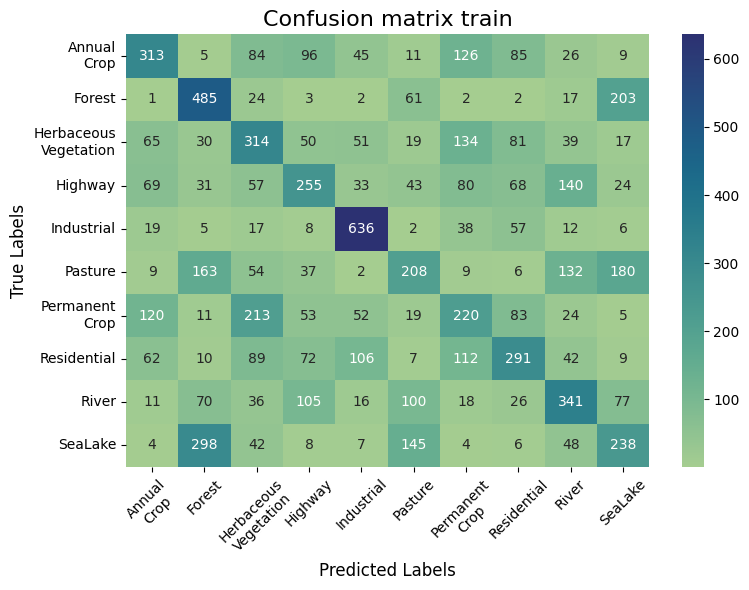

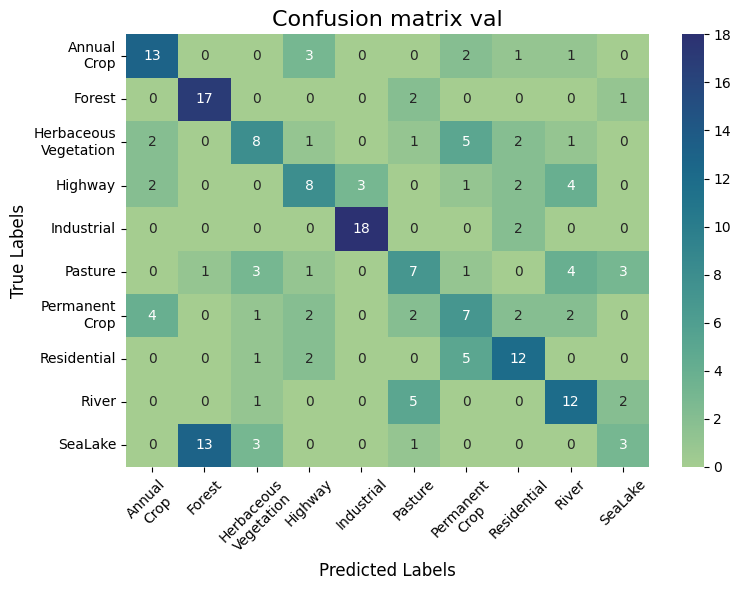

In [8]:
trainer.fit()

In [9]:
model = HQNN_Parallel(amplitude_encoding_params, strongly_entangled_circuit_params, measurement_params, use_quantum=True)


In [10]:
trainer = Trainer(model = model,
                  train_loader = train_loader,
                  val_loader = val_loader,
                  epochs = epochs,
                  early_stopping = early_stopping,
                  patience = patience,
                  use_quantum = use_quantum,
                  plot = plot,
                  allowed_classes = allowed_classes,
                  lr = learning_rate,
                  use_schedulefree=True
                 )

2025-03-24 15:59:11.493 | DEBUG    | src.utils.training:fit:226 - Epoch [1/10]: Train Loss = 2.3041, Train Acc = 11.25%, Val Loss = 2.2314, Val Acc = 14.00%
2025-03-24 15:59:12.821 | DEBUG    | src.utils.training:fit:226 - Epoch [2/10]: Train Loss = 2.1212, Train Acc = 16.75%, Val Loss = 2.0401, Val Acc = 20.00%
2025-03-24 15:59:14.274 | DEBUG    | src.utils.training:fit:226 - Epoch [3/10]: Train Loss = 2.0431, Train Acc = 20.12%, Val Loss = 1.9245, Val Acc = 23.50%
2025-03-24 15:59:15.612 | DEBUG    | src.utils.training:fit:226 - Epoch [4/10]: Train Loss = 1.8772, Train Acc = 24.25%, Val Loss = 1.8547, Val Acc = 28.00%
2025-03-24 15:59:16.959 | DEBUG    | src.utils.training:fit:226 - Epoch [5/10]: Train Loss = 1.7728, Train Acc = 28.50%, Val Loss = 1.7915, Val Acc = 29.50%
2025-03-24 15:59:18.238 | DEBUG    | src.utils.training:fit:226 - Epoch [6/10]: Train Loss = 1.7294, Train Acc = 28.88%, Val Loss = 1.7484, Val Acc = 29.00%
2025-03-24 15:59:19.504 | DEBUG    | src.utils.training:fi

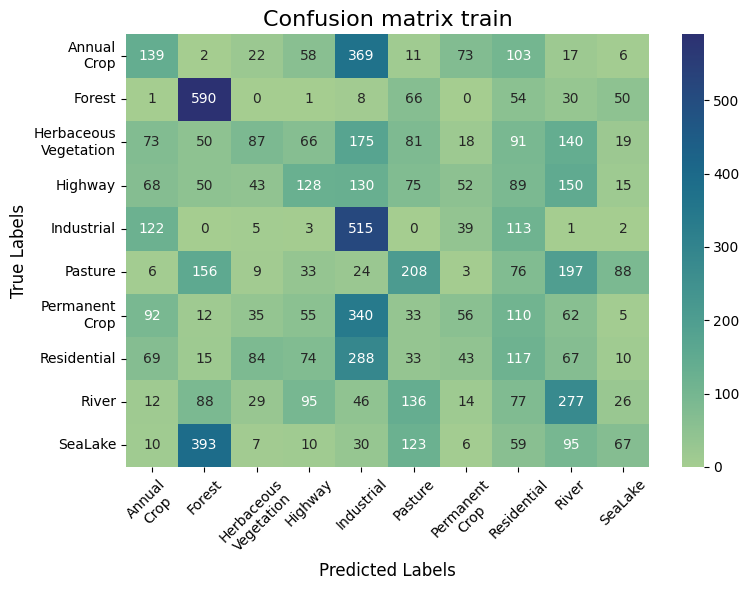

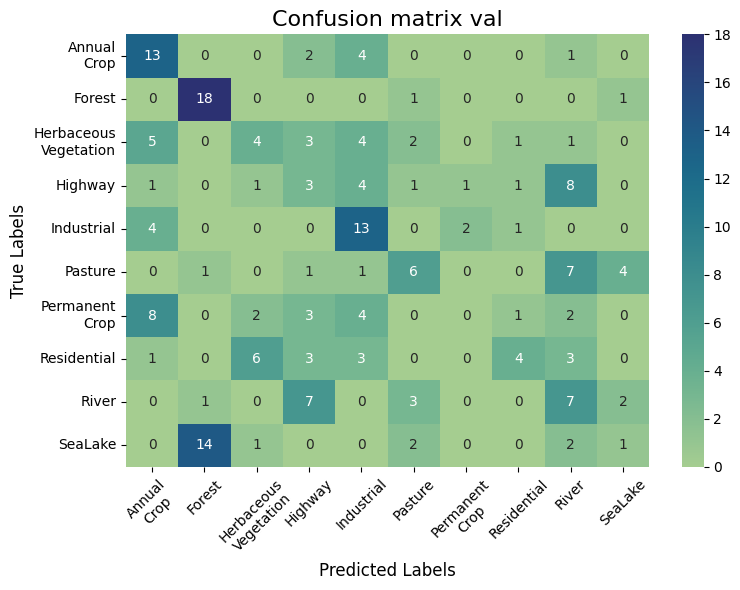

In [11]:
trainer.fit()

# HQNN_Parallel - 16x16x3

In [12]:
%pwd

'/Users/uribagi/Documents/GitHub/QML-Satellite-Image-Classification'

In [13]:
%cd notebooks
limit = 100
dataset_ = "DeepSat4"
image_size = 16
test_size = 0.2
output = 'np' # 'np' or 'dl'
batch_size = 16

if dataset_ == "EuroSAT":
    allowed_classes = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
elif dataset_ == "DeepSat4":
    allowed_classes = ['BarrenLand', 'Trees', 'Grassland', 'Other']
elif dataset_ == "DeepSat6":
    allowed_classes = ['BarrenLand', 'Trees', 'Grassland', 'Roads', 'Buildings' , 'WaterBodies']

config = {
    #'allowed_classes': ['Forest', 'Highway', 'Pasture', 'SeaLake']
    #'allowed_classes': ['AnnualCrop', 'Forest', 'Highway', 'Pasture', 'River', 'SeaLake']
}

allowed_classes = config.get('allowed_classes', allowed_classes)
train_loader, val_loader = load_dataset(dataset_, output, limit, allowed_classes, image_size, test_size, batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(f"Using device: {device}")
torch.backends.cudnn.benchmark = True

/Users/uribagi/Documents/GitHub/QML-Satellite-Image-Classification/notebooks


In [14]:
use_quantum, log_wandb, plot = False, False, True
n_classes = len(allowed_classes)
early_stopping, patience = False, 4

name_run = "HQNN_Parallel"
num_qubits_per_circuit = 8
learning_rate = 0.01
epochs = 10

print("Testing with the", dataset_, "dataset")

Testing with the DeepSat4 dataset


In [15]:
amplitude_encoding_params = {
    "func":  amplitude_embedding,
    "func_params": {
        "normalize" : True,
        "pad_with": 0.0,
    }
}

angle_encoding_params = {
    "func": angle_embedding,
    "func_params": {
        "rotation" : "X"
    }
}

waterfall_encoding_params = {
    "func": waterfall_embedding,
    "func_params": {

    }
}

iqp_encoding_params = {
    "func": custom_iqp_embedding,
    "func_params": {
        "n_repeats": 2,
        "pattern": None
    }
}

num_layers = 2
weights_strongly_entangled = (2 * torch.rand(num_layers, num_qubits_per_circuit, 3) - 1) * np.pi
weights_random = (2 * torch.rand(num_layers, num_qubits_per_circuit, 3) - 1) * np.pi

default_circuit_params = {
    "func": default_circuit,
    "func_params": {
        "num_layers": num_layers,
        "weights": weights_random,
        "weight_shapes": {"weights": (num_layers, num_qubits_per_circuit)},
    }
}

strongly_entangled_circuit_params = {
    "func": custom_circuit,
    "func_params": {
        "num_layers": num_layers,
        "weights": weights_strongly_entangled,
        "weight_shapes": {"weights": (num_layers, num_qubits_per_circuit, 3)},
    }
}

measurement_params = {
    "func": default_measurement,
    "func_params": {
        "observable": qml.PauliX,
        "measured_qubits": range(num_qubits_per_circuit),
    }
}

In [16]:
model = HQNN_Parallel(iqp_encoding_params, strongly_entangled_circuit_params, measurement_params, use_quantum=False, input_size=16, dataset="DeepSat4")

In [17]:
trainer = Trainer(model = model,
                  train_loader = train_loader,
                  val_loader = val_loader,
                  epochs = epochs,
                  early_stopping = early_stopping,
                  patience = patience,
                  use_quantum = use_quantum,
                  plot = plot,
                  allowed_classes = allowed_classes,
                  lr = learning_rate,
                  use_schedulefree=True
                 )

2025-03-24 15:59:29.257 | DEBUG    | src.utils.training:fit:226 - Epoch [1/10]: Train Loss = 1.7660, Train Acc = 20.31%, Val Loss = 1.4387, Val Acc = 25.00%
2025-03-24 15:59:29.312 | DEBUG    | src.utils.training:fit:226 - Epoch [2/10]: Train Loss = 1.4117, Train Acc = 20.00%, Val Loss = 1.3883, Val Acc = 25.00%
2025-03-24 15:59:29.352 | DEBUG    | src.utils.training:fit:226 - Epoch [3/10]: Train Loss = 1.4031, Train Acc = 22.19%, Val Loss = 1.3819, Val Acc = 32.50%
2025-03-24 15:59:29.391 | DEBUG    | src.utils.training:fit:226 - Epoch [4/10]: Train Loss = 1.3686, Train Acc = 30.31%, Val Loss = 1.3246, Val Acc = 41.25%
2025-03-24 15:59:29.444 | DEBUG    | src.utils.training:fit:226 - Epoch [5/10]: Train Loss = 1.3662, Train Acc = 32.50%, Val Loss = 1.2928, Val Acc = 30.00%
2025-03-24 15:59:29.484 | DEBUG    | src.utils.training:fit:226 - Epoch [6/10]: Train Loss = 1.2995, Train Acc = 38.12%, Val Loss = 1.1698, Val Acc = 43.75%
2025-03-24 15:59:29.525 | DEBUG    | src.utils.training:fi

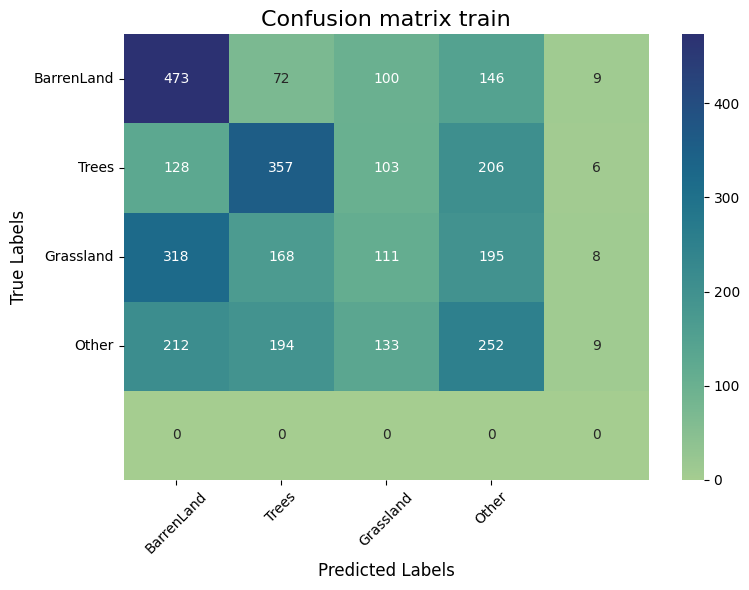

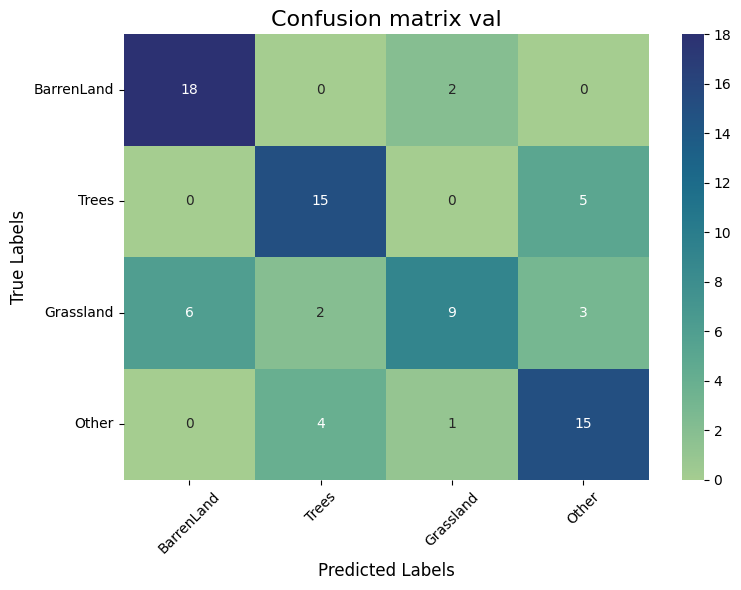

In [18]:
trainer.fit()

In [19]:
model = HQNN_Parallel(iqp_encoding_params, strongly_entangled_circuit_params, measurement_params, use_quantum=True, input_size=16 , dataset="DeepSat4")

In [20]:
trainer = Trainer(model = model,
                  train_loader = train_loader,
                  val_loader = val_loader,
                  epochs = epochs,
                  early_stopping = early_stopping,
                  patience = patience,
                  use_quantum = use_quantum,
                  plot = plot,
                  allowed_classes = allowed_classes,
                  lr = learning_rate,
                  use_schedulefree=True
                 )

2025-03-24 15:59:59.480 | DEBUG    | src.utils.training:fit:226 - Epoch [1/10]: Train Loss = 1.6192, Train Acc = 20.00%, Val Loss = 1.4233, Val Acc = 25.00%
2025-03-24 16:00:31.384 | DEBUG    | src.utils.training:fit:226 - Epoch [2/10]: Train Loss = 1.4141, Train Acc = 25.31%, Val Loss = 1.3638, Val Acc = 26.25%
2025-03-24 16:01:02.761 | DEBUG    | src.utils.training:fit:226 - Epoch [3/10]: Train Loss = 1.3532, Train Acc = 37.81%, Val Loss = 1.2720, Val Acc = 50.00%
2025-03-24 16:01:34.697 | DEBUG    | src.utils.training:fit:226 - Epoch [4/10]: Train Loss = 1.3152, Train Acc = 37.81%, Val Loss = 1.1549, Val Acc = 55.00%
2025-03-24 16:02:06.392 | DEBUG    | src.utils.training:fit:226 - Epoch [5/10]: Train Loss = 1.3853, Train Acc = 33.12%, Val Loss = 1.1139, Val Acc = 45.00%
2025-03-24 16:02:38.976 | DEBUG    | src.utils.training:fit:226 - Epoch [6/10]: Train Loss = 1.3203, Train Acc = 36.25%, Val Loss = 1.1541, Val Acc = 47.50%
2025-03-24 16:03:11.265 | DEBUG    | src.utils.training:fi

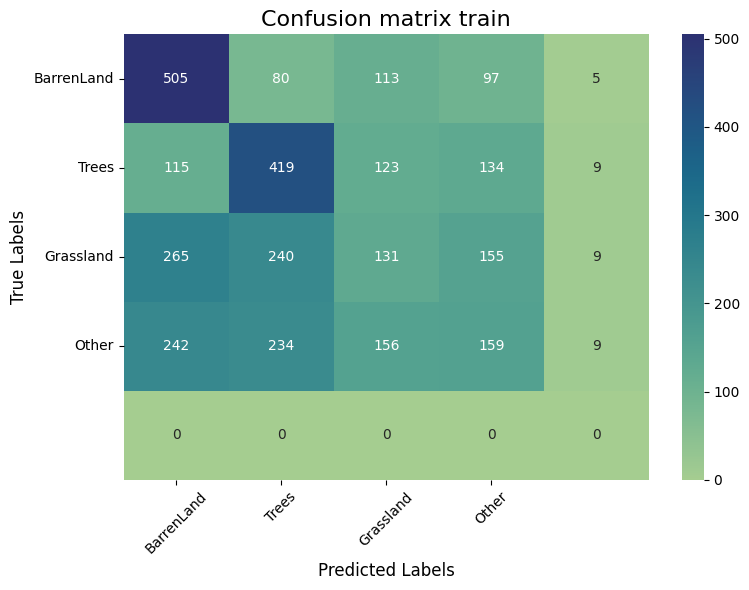

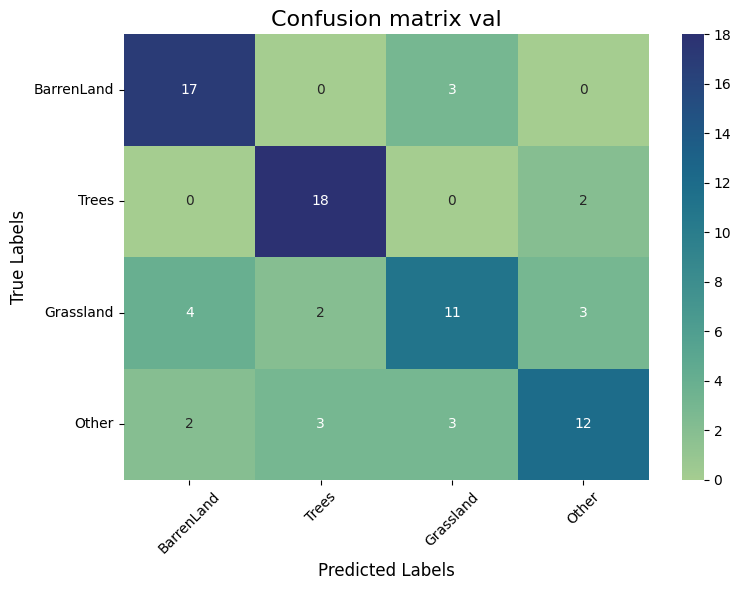

In [21]:
trainer.fit()